# Vacquerie_Justin_3_notebook_prediction_consommation_042024

Dans ce notebook, nous allons procéder à la modélisation, en utilisant différents modèles de ML, pour répondre à la question :
- prédire la consommation de nouveaux bâtiments

Pour cela, nous utiliserons différents modèles sur notre dataset, nettoyé et préparé, à travers le notebook exploratoire.

Voici la liste des modèles d'apprentissage que nous utiliserons :
- l'elastic net
- le PLS
- le SVM
- le Gradient Boosting
- le Random Forest

Avant de se lancer, dans la phase de modélisation, je vais expliciter en amont la démarche qui sera employée, pour structurer et cadrer notre étude.
L'objectif est d'avoir une ligne directrice, ce qui faciliera la compréhension de nos résultats et la comparaison de nos différents algorithmes qui auront été mis en oeuvre.

**Objectif** : avoir un modèle ayant un R² d'au moins **0.8**

**La démarche employée :** (équivalente à celle pour les prédictions pour les émissions en CO2)

- **Feature Selection avec stats model**

- **Modélisation:**

1. Définir les métriques d'évaluation de nos modèles. Dans notre cas, nous utiliserons 2 métriques, qui seront principalement **le R² et la MAPE.**

Mon choix se porte sur ces deux métriques car elles sont facilement interprétables, notamment dans notre situation où somme face à des valeurs très importantes si nous prenoms le MAE et RMSE

2. Utiliser les transformers de scikit-learn, pour la normalisation & la création d'un test set & train set, sur une base 80% / 20%.
   Ici, pour la normalisation, nous utiliserons systématiquement le 'Robust Scaler' qui est le moins sensible aux outliers.
   (des tests en amont ont démontré la supériorité de ce transformer par rapport au StandardScaler ou le MinMaxScaler)

**Approche data-centric :**
La première approche sera de mettre en avant la qualité des données, en testant 5 modèles de manière simple sans jouer avec les hyper-paramètres.
Cette partie va nous permettre de répondre à la question :

**Quels modèles sont les plus performants & dans quelle situtation concernant la configuration du dataset ?** 

3. Tester nos 5 modèles choisis selon les situations suivantes :
- Avec ou sans la variable surface totale, c'est-à-dire dans un cas où celle-ci est présente dans notre dataset et la valeur dans la
- Avec ou sans la transformation log de notre variable y
- Avec ou sans le feature selection en amont

4. Lire les résultats obtenus sur les métriques R² & MAPE

5. Choisir le couple 'modèle d'apprentissage / dataset' les plus performants

**Approche model-centric :**
Cette seconde partie se concentrera sur la seconde approche qui est l'approche model-centric. Ici, nous tenterons d'optimiser notre couple pour améliorer notre R² & MAPE, en ajustant les hyper-paramètres disponibles sur le modèle en question. Nous utiliserons notamment une validation croisée & une GridSearchCV disponible avec Scikit-Learn.

6. Lancer le couple 'modèle d'apprentissage / dataset' retenus dans la partie précédente
7. Lancer une cross-validation pour mesurer la robustesse du modèle et sa capacité à généraliser
8. Utiliser une GridSearchCV pour gagner en performance en testant plusieurs configuration d'hyperparamètres (si possible) 

La modélisation est un processus itératif et cyclique, où le but est d'entrainer, interprêter et ajuster selon les résultats obtenus. 



# I. Importer les librairies & le fichier au format 'csv'

## 1. Importer les librairies et les dataframes en csv

**Importer les librairies utilisées dans ce notebook jupyter**

In [4]:
# Librairies standards pour python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno
from tqdm import tqdm

# Librairies pour le machine learning les modèles
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

# Librairies de pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Librairies pour les indicateurs de performances du modèle
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import time

# Librairies pour l'analyse de l'influence des features
import lime
import lime.lime_tabular
import shap

# Analyse statistique
from scipy import stats
from scipy.stats import norm
import statsmodels.formula.api as smf

In [2]:
# Importer le fichier 'csv' avec Pandas, dans un dataframe 'df' sans la surface totale
data = pd.read_csv('df_ml_conso.csv')
df = data.copy()

In [3]:
# Importer le fichier 'csv' avec Pandas, dans un dataframe 'df_sf' avec la surface totale
data_sf = pd.read_csv('df_ml_conso_sf.csv')
df_sf = data_sf.copy()

## 2. Visualiser les dataset

In [4]:
# Vérification du dataframe 
pd.set_option('display.max_columns', None)
df.head(15)

,Age_batiment,NbEtages,Conso_Totale_WN,Conso_GazNat_kBtu_WN,Conso_Vapeur_kBtu_WN,Conso_Elec_kBtu_WN,Data Center,Distribution Center,Food Service,Hospital (General Medical & Surgical),Laboratory,Museum,Non-Refrigerated Warehouse,Other,Other - Recreation,Other - Restaurant/Bar,Other - Utility,Other/Specialty Hospital,Parking,Performing Arts,Police Station,Pre-school/Daycare,Restaurant,Self-Storage Facility,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Worship Facility,Conso_totale_WN_log,rateParking,rateBuilding,surfaceEtage,surfaceParBat,nombre_usages
0,89,12,7.420717e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.819786,0.0000,1.0000,7369.5000,88434.0,1
1,20,11,8.613529e+06,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.968845,0.1455,0.8545,9415.0909,103566.0,3
2,47,41,7.453927e+07,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,756493.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.126837,0.2600,0.7400,18451.0488,756493.0,1
3,90,10,6.977326e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.758176,0.0000,1.0000,6132.0000,61320.0,1
4,36,18,1.455378e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.493361,0.3238,0.6762,10636.3333,191454.0,3
5,17,2,1.241169e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88830.0,0.0,0.0,0.0,0.0,0.0,0.0,16.334149,0.4188,0.5812,44415.0000,88830.0,1
6,90,11,5.913680e+06,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.592779,0.0000,1.0000,7395.6364,81352.0,1
7,90,8,6.467521e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.682303,0.0000,1.0000,12845.1250,102761.0,1
8,112,15,1.409293e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.461183,0.0000,1.0000,10932.2667,163984.0,1
9,47,11,1.644742e+07,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.615679,0.1440,0.8560,12171.2727,133884.0,1


In [5]:
# Importer le fichier 'csv' avec Pandas, dans un dataframe 'df_sf'
pd.set_option('display.max_columns', None)
df_sf.head(15)

,Age_batiment,Surface_totale,NbEtages,Conso_Totale_WN,Conso_GazNat_kBtu_WN,Conso_Vapeur_kBtu_WN,Conso_Elec_kBtu_WN,Data Center,Distribution Center,Food Service,Hospital (General Medical & Surgical),Laboratory,Museum,Non-Refrigerated Warehouse,Other,Other - Recreation,Other - Restaurant/Bar,Other - Utility,Other/Specialty Hospital,Parking,Performing Arts,Police Station,Pre-school/Daycare,Restaurant,Self-Storage Facility,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Worship Facility,Conso_totale_WN_log,rateParking,rateBuilding,surfaceEtage,surfaceParBat,nombre_usages
0,89,88434.0,12,7.420717e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.819786,0.0000,1.0000,7369.5000,88434.0,1
1,20,103566.0,11,8.613529e+06,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.968845,0.1455,0.8545,9415.0909,103566.0,3
2,47,756493.0,41,7.453927e+07,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.126837,0.2600,0.7400,18451.0488,756493.0,1
3,90,61320.0,10,6.977326e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.758176,0.0000,1.0000,6132.0000,61320.0,1
4,36,191454.0,18,1.455378e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.493361,0.3238,0.6762,10636.3333,191454.0,3
5,17,88830.0,2,1.241169e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.334149,0.4188,0.5812,44415.0000,88830.0,1
6,90,81352.0,11,5.913680e+06,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.592779,0.0000,1.0000,7395.6364,81352.0,1
7,90,102761.0,8,6.467521e+06,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.682303,0.0000,1.0000,12845.1250,102761.0,1
8,112,163984.0,15,1.409293e+07,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.461183,0.0000,1.0000,10932.2667,163984.0,1
9,47,133884.0,11,1.644742e+07,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.615679,0.1440,0.8560,12171.2727,133884.0,1


# II. Features selection avec OLS StatsModel

Dans cette partie, nous allons analyser l'intérêt de chacune de nos features dans notre modèle de régression grâce la librairie StatsModel. Avec la fonction OLS nous allons pouvoir mesurer notre modèle de manière globale avec un premier R², ainsi que l'importance de chacune des caractéristiques. Cela va nous permettre de faire pré-sélection de nos features à entrainer dans nos modèles de ML.
La valeur p aide à déterminer si les coefficients estimés sont fiables et si les variables indépendantes ont un effet significatif sur la variable dépendante dans le modèle de régression.

## 1. Analyse sur le dataframe avec la feature surface totale éclatée sur les usages

In [6]:
# Créer un nouveau df
df_fs = data.copy()

In [7]:
# Afficher les colonnes et la structure du df
print(df_fs.columns)
print(df_fs.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_Totale_WN', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data Center',
       'Distribution Center', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Laboratory', 'Museum',
       'Non-Refrigerated Warehouse', 'Other', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Utility', 'Other/Specialty Hospital',
       'Parking', 'Performing Arts', 'Police Station', 'Pre-school/Daycare',
       'Restaurant', 'Self-Storage Facility', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Worship Facility',
       'Conso_totale_WN_log', 'rateParking', 'rateBuilding', 'surfaceEtage',
       'surfaceParBat', 'nombre_usages'],
      dtype='object')
(1382, 33)


In [8]:
# Tranformer le nom des variables pour qu'elles puissent être intégrées dans le code OLS de StatsModel
df_fs.columns = ['Age_batiment',
       'NbEtages', 'Conso_Totale_WN', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Food_Service',
       'Hospital_General_Medical_Surgical', 'Laboratory', 'Museum',
       'Non_Refrigerated_Warehouse', 'Other', 'Other_Recreation',
       'Other_Restaurant_Bar', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Performing_Arts', 'Police_Station', 'Pre_school_Daycare',
       'Restaurant', 'Self_Storage_Facility', 'Supermarket_Grocery_Store',
       'Urgent_Care_Clinic_Other_Outpatient', 'Worship_Facility',
       'Conso_totale_WN_log', 'rateParking', 'rateBuilding', 'surfaceEtage',
       'surfaceParBat', 'nombre_usages']

In [9]:
# Lancer le module OLS de Stats-Model
reg_multi = smf.ols('Conso_Totale_WN ~ Age_batiment + NbEtages + Conso_GazNat_kBtu_WN + Conso_Vapeur_kBtu_WN + Conso_Elec_kBtu_WN + Data_Center + Distribution_Center + Hospital_General_Medical_Surgical + Laboratory + Museum + Non_Refrigerated_Warehouse + Other + Other_Recreation + Other_Utility + Other_Specialty_Hospital + Parking + Police_Station + Restaurant + Self_Storage_Facility + Supermarket_Grocery_Store + Urgent_Care_Clinic_Other_Outpatient + Worship_Facility + rateBuilding + surfaceEtage + surfaceParBat', data=df_fs).fit()
print(reg_multi.summary())


                            OLS Regression Results                            
Dep. Variable:        Conso_Totale_WN   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     754.0
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:59:35   Log-Likelihood:                -23752.
No. Observations:                1382   AIC:                         4.756e+04
Df Residuals:                    1356   BIC:                         4.769e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

Nous remarquons que le R² sorti de l'OLS de Stats Model semble engageant avec une valeur de 0.933 qui est un bon niveau. Cela nous indique que nous avons un certains potentiel dans nos données pour effectuer des prédictions de notre target.

In [10]:
# Stocker les colonnes à retirer, celles qui ont la plus forte p-Value
col_a_retirer = ['nombre_usages',
                 'Food_Service',
                 'Pre_school_Daycare',
                 'rateParking',
                 'Other_Restaurant_Bar',
                 'Performing_Arts',
                ]
# Suppression des colonnes du df_fs
df_fs.drop(col_a_retirer, axis=1, inplace=True)
print(df_fs.shape)

(1382, 27)


## 2. Analyse sur le dataframe avec la présence de la variable surface totale & pondération sur les usages

In [11]:
# Créer un nouveau df
df_fs_sf = data_sf.copy()

In [12]:
# Afficher les colonnes et la structure du df
print(df_fs_sf.columns)
print(df_fs_sf.shape)

Index(['Age_batiment', 'Surface_totale', 'NbEtages', 'Conso_Totale_WN',
       'Conso_GazNat_kBtu_WN', 'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN',
       'Data Center', 'Distribution Center', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Laboratory', 'Museum',
       'Non-Refrigerated Warehouse', 'Other', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Utility', 'Other/Specialty Hospital',
       'Parking', 'Performing Arts', 'Police Station', 'Pre-school/Daycare',
       'Restaurant', 'Self-Storage Facility', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Worship Facility',
       'Conso_totale_WN_log', 'rateParking', 'rateBuilding', 'surfaceEtage',
       'surfaceParBat', 'nombre_usages'],
      dtype='object')
(1382, 34)


In [13]:
# Tranformer le nom des variables pour qu'elles puissent être intégrées dans le code OLS de StatsModel
df_fs_sf.columns = ['Age_batiment', 'Surface_totale',
       'NbEtages', 'Conso_Totale_WN', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Food_Service',
       'Hospital_General_Medical_Surgical', 'Laboratory', 'Museum',
       'Non_Refrigerated_Warehouse', 'Other', 'Other_Recreation',
       'Other_Restaurant_Bar', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Performing_Arts', 'Police_Station', 'Pre_school_Daycare',
       'Restaurant', 'Self_Storage_Facility', 'Supermarket_Grocery_Store',
       'Urgent_Care_Clinic_Other_Outpatient', 'Worship_Facility',
       'Conso_totale_WN_log', 'rateParking', 'rateBuilding', 'surfaceEtage',
       'surfaceParBat', 'nombre_usages']

In [14]:
# Lancer le module OLS de Stats-Model
reg_multi = smf.ols('Conso_Totale_WN ~ Surface_totale + Age_batiment + NbEtages + Conso_GazNat_kBtu_WN + Conso_Vapeur_kBtu_WN + Data_Center + Distribution_Center + Hospital_General_Medical_Surgical + Laboratory + Non_Refrigerated_Warehouse + Other_Specialty_Hospital + Parking + Police_Station + Restaurant + Self_Storage_Facility + Supermarket_Grocery_Store + Urgent_Care_Clinic_Other_Outpatient + Worship_Facility + rateBuilding + surfaceEtage + surfaceParBat +nombre_usages', data=df_fs_sf).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:        Conso_Totale_WN   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     479.4
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:59:38   Log-Likelihood:                -24119.
No. Observations:                1382   AIC:                         4.828e+04
Df Residuals:                    1359   BIC:                         4.841e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [15]:
# Stocker les colonnes à retirer, celles qui ont la plus forte p-Value
col_a_retirer = ['Other',
                 'Other_Recreation',
                 'Conso_Elec_kBtu_WN',
                 'Other_Utility',
                 'Museum'
                ]
# Suppression des colonnes du df_fs
df_fs_sf.drop(col_a_retirer, axis=1, inplace=True)
print(df_fs_sf.shape)

(1382, 29)


# III. Première modélisation sur 5 algorithmes (approche data-centric)

Dans ce modèle nous avons :
- La variable y avec la consommation totale indexée aux données météo (avec ou sans la fonction log)

Et voici les features qui formeront la matrice X :

- Les types d'utilisations
- Les données structurelles des bâtiments

Ces premières modélisations vont permettre de faire dans un premier une sélection sur 5 algorithmes qui nous lancerons et entrainerons. Nous allons également étudier l'impact de trois paramètres différents sur ces 5 algorithmes :

- la pondération ou non de la surface totale
- le features selection ou non avec OLS de Stats Model
- la transformation en log de notre variable cible

A la fin de cette troisième partie, nous devrions avoir sélectionné  1 ou 2 algorithmes avec le meilleur R² et avec quelle configuration celui-ci à répondu avec les meilleurs résultats. 
Dans la partie suivante, nous approfondirons l'exploitation de ces algoritmes retenus, pour comprendre leur fonctionnement et ainsi tenter d'améliorer le R², notamment en jouant avec les hyperparamètres et tester la robustesse des modèles via des validations croisées.

## A. Modélisation : avec ou sans la pondération de la variable surface totale (avec la feature selection)

### 1. Avec la pondération de la surface totale par usage (sans la variable surface_totale)

In [66]:
# Création d'un dataframe dédié pour la 1iere modélisation
dfA1 = df_fs.copy()

In [67]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = dfA1.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = dfA1['Conso_Totale_WN']

In [68]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Hospital_General_Medical_Surgical',
       'Laboratory', 'Museum', 'Non_Refrigerated_Warehouse', 'Other',
       'Other_Recreation', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Police_Station', 'Restaurant', 'Self_Storage_Facility',
       'Supermarket_Grocery_Store', 'Urgent_Care_Clinic_Other_Outpatient',
       'Worship_Facility', 'rateBuilding', 'surfaceEtage', 'surfaceParBat'],
      dtype='object')
(1382, 25)


In [69]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 25)
(277, 25)


In [70]:
# Initialiser les modèles
models = {
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000),
    "PLS": PLSRegression(n_components=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(kernel='linear') 
}

# Initialiser les listes pour stocker les scores et les temps d'exécution
r2_scores = []
mape_scores = []
execution_times = []

# Entraîner et évaluer les modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2_scores.append(r2)  
    mape_scores.append(mape) 
    # Calculer et stocker le temps d'exécution
    start_time = time.time()
    model.predict(X_test) 
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time) 
    print(f"Model: {name}")
    print(f"R² Score: {r2}")
    print(f"MAPE: {mape}")
    print(f"Execution Time: {execution_time} seconds")
    print("----------------------")


Model: Elastic Net
R² Score: 0.7779930091519212
MAPE: 1.0837875010685505
Execution Time: 0.0029222965240478516 seconds
----------------------
Model: PLS
R² Score: 0.7750903809913974
MAPE: 1.1226823912990667
Execution Time: 0.0 seconds
----------------------
Model: Gradient Boosting
R² Score: 0.642288415502358
MAPE: 1.1184066361434493
Execution Time: 0.009890317916870117 seconds
----------------------
Model: Random Forest
R² Score: 0.4066414100356557
MAPE: 2.9696414864053815
Execution Time: 0.019999980926513672 seconds
----------------------
Model: SVR
R² Score: 0.7480121050595181
MAPE: 0.6776884727249104
Execution Time: 0.009999752044677734 seconds
----------------------


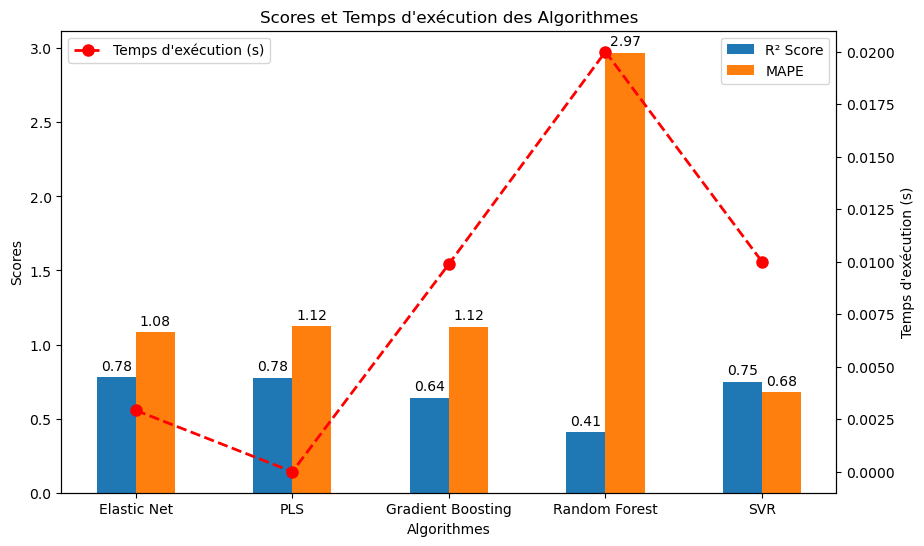

In [71]:
# Créer le graphique en barres
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(models))

bar1 = ax1.bar(index, r2_scores, bar_width, label='R² Score')
bar2 = ax1.bar(index + bar_width, mape_scores, bar_width, label='MAPE')

ax1.set_xlabel('Algorithmes')
ax1.set_ylabel('Scores')
ax1.set_title('Scores et Temps d\'exécution des Algorithmes')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models.keys())

# Ajouter des étiquettes de valeur aux barres
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax1, bar1)
add_value_labels(ax1, bar2)

# Créer un deuxième axe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, execution_times, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Temps d\'exécution (s)')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.legend(loc='upper left')  # Déplacer la légende vers le coin supérieur gauche

# Ajouter une légende pour les scores
ax1.legend(loc='upper right')

# Afficher le graphique
plt.show()


invalid value encountered in log
invalid value encountered in log


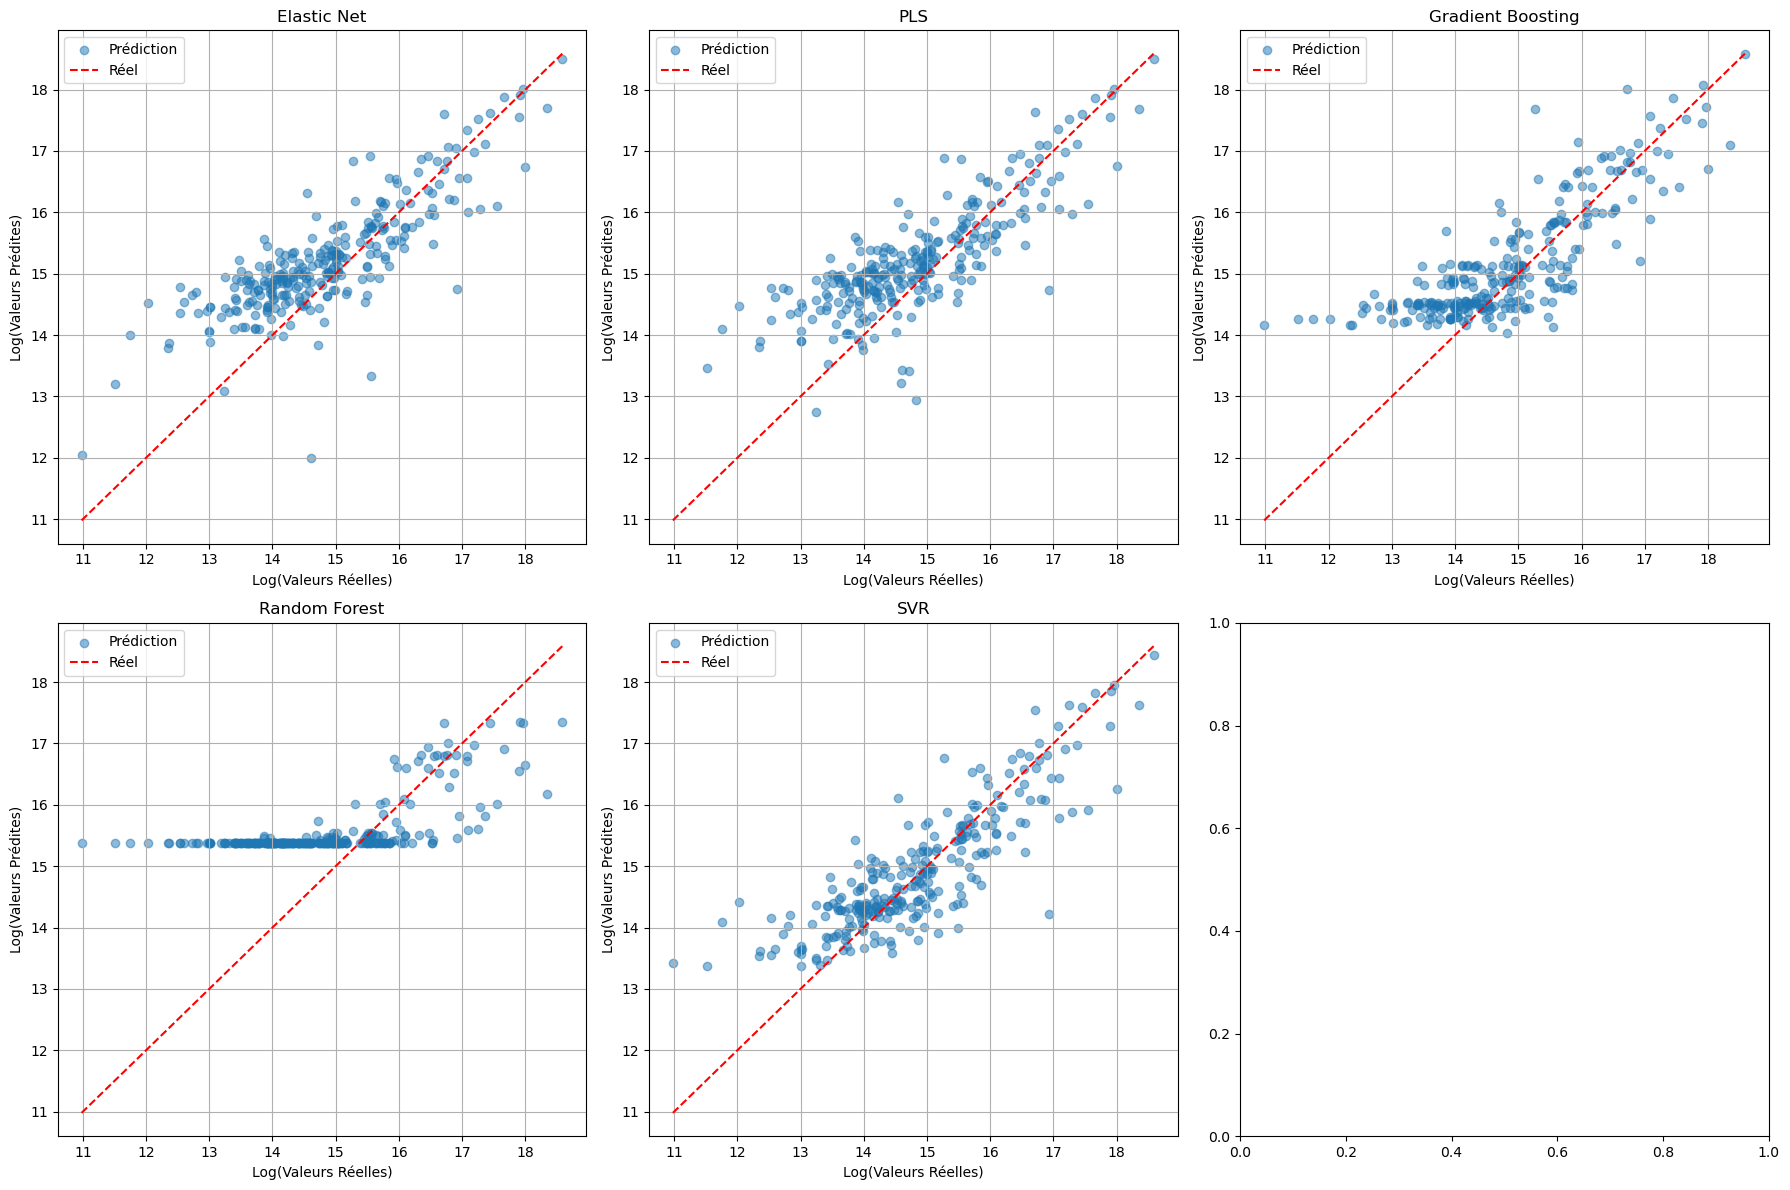

In [72]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Liste des modèles à visualiser
model_names = list(models.keys())

# Parcourir chaque modèle pour tracer le nuage de points
for i, (name, model) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.set_title(name)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Tracer le nuage de points
    ax.scatter(np.log(y_test), np.log(predictions), alpha=0.5)
    ax.plot([min(np.log(y_test)), max(np.log(y_test))], [min(np.log(y_test)), max(np.log(y_test))], color='red', linestyle='--')
    
    # Ajouter des étiquettes et légendes
    ax.set_xlabel('Log(Valeurs Réelles)')
    ax.set_ylabel('Log(Valeurs Prédites)')
    ax.legend(['Prédiction', 'Réel'])
    ax.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


### 2. Sans la pondération de la surface totale par usage (présence de la variable surface_totale)

In [22]:
# Création d'un dataframe dédié pour la 1iere modélisation
dfA2 = df_fs_sf.copy()

In [23]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = dfA2.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = dfA2['Conso_Totale_WN']

In [24]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 32)
(277, 32)


In [25]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'Surface_totale', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Food_Service',
       'Hospital_General_Medical_Surgical', 'Laboratory', 'Museum',
       'Non_Refrigerated_Warehouse', 'Other', 'Other_Recreation',
       'Other_Restaurant_Bar', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Performing_Arts', 'Police_Station', 'Pre_school_Daycare',
       'Restaurant', 'Self_Storage_Facility', 'Supermarket_Grocery_Store',
       'Urgent_Care_Clinic_Other_Outpatient', 'Worship_Facility',
       'rateParking', 'rateBuilding', 'surfaceEtage', 'surfaceParBat',
       'nombre_usages'],
      dtype='object')
(1382, 32)


In [26]:
# Initialiser les modèles
models = {
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000),
    "PLS": PLSRegression(n_components=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(kernel='rbf') 
}

# Initialiser les listes pour stocker les scores et les temps d'exécution
r2_scores = []
mape_scores = []
execution_times = []

# Entraîner et évaluer les modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2_scores.append(r2)  
    mape_scores.append(mape) 
    # Calculer et stocker le temps d'exécution
    start_time = time.time()
    model.predict(X_test) 
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time) 
    print(f"Model: {name}")
    print(f"R² Score: {r2}")
    print(f"MAPE: {mape}")
    print(f"Execution Time: {execution_time} seconds")
    print("----------------------")


Model: Elastic Net
R² Score: 0.7457249562016139
MAPE: 1.537462068982602
Execution Time: 0.008027315139770508 seconds
----------------------
Model: PLS
R² Score: -0.15642867069333888
MAPE: 1.2749664675029126
Execution Time: 0.0009510517120361328 seconds
----------------------
Model: Gradient Boosting
R² Score: 0.5010294278655905
MAPE: 1.1170592106098416
Execution Time: 0.0 seconds
----------------------
Model: Random Forest
R² Score: 0.5387860681974264
MAPE: 2.4228118250987616
Execution Time: 0.009853363037109375 seconds
----------------------
Model: SVR
R² Score: -0.08587907367525816
MAPE: 1.6213501962003831
Execution Time: 0.052950382232666016 seconds
----------------------


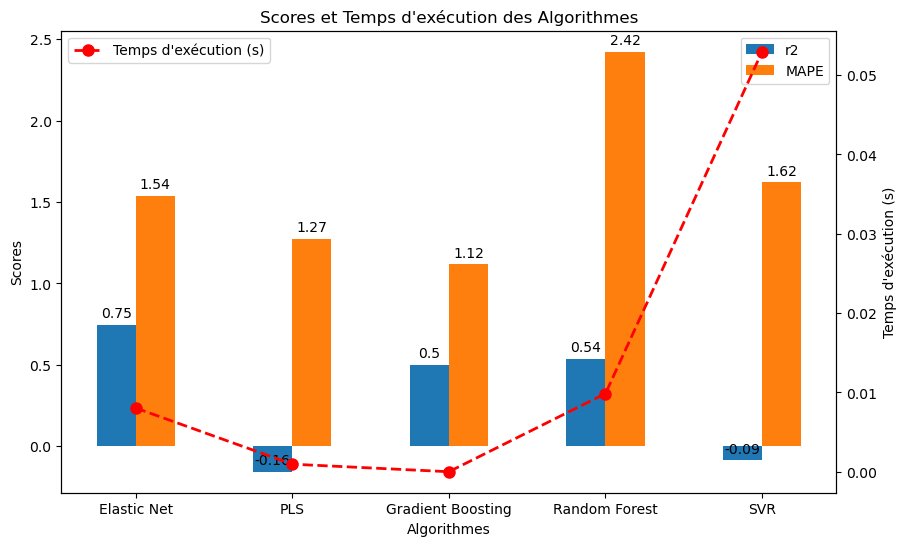

In [27]:
# Créer le graphique en barres
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(models))

bar1 = ax1.bar(index, r2_scores, bar_width, label='r2')
bar2 = ax1.bar(index + bar_width, mape_scores, bar_width, label='MAPE')

ax1.set_xlabel('Algorithmes')
ax1.set_ylabel('Scores')
ax1.set_title('Scores et Temps d\'exécution des Algorithmes')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models.keys())

# Ajouter des étiquettes de valeur aux barres
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax1, bar1)
add_value_labels(ax1, bar2)

# Créer un deuxième axe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, execution_times, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Temps d\'exécution (s)')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.legend(loc='upper left')  # Déplacer la légende vers le coin supérieur gauche

# Ajouter une légende pour les scores
ax1.legend(loc='upper right')

# Afficher le graphique
plt.show()


invalid value encountered in log
invalid value encountered in log


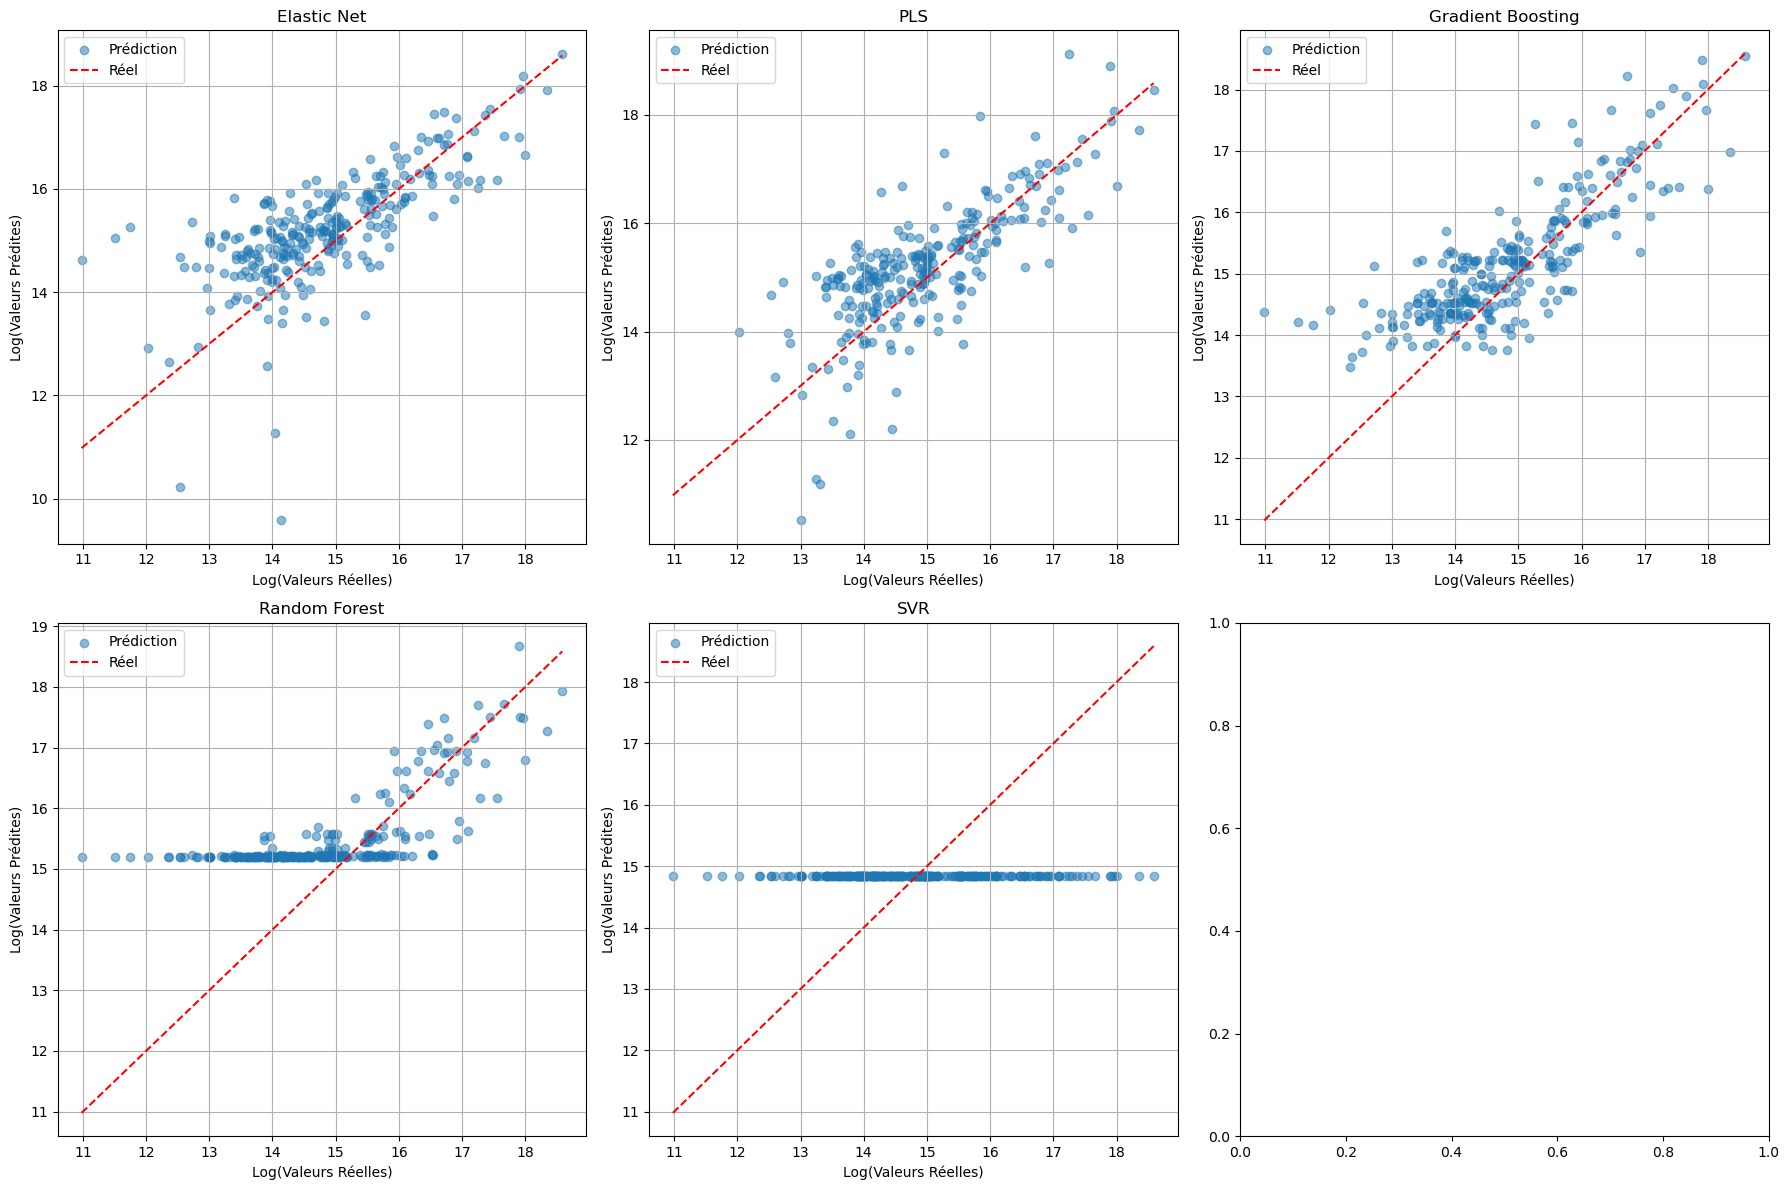

In [21]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Liste des modèles à visualiser
model_names = list(models.keys())

# Parcourir chaque modèle pour tracer le nuage de points
for i, (name, model) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.set_title(name)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Tracer le nuage de points
    ax.scatter(np.log(y_test), np.log(predictions), alpha=0.5)
    ax.plot([min(np.log(y_test)), max(np.log(y_test))], [min(np.log(y_test)), max(np.log(y_test))], color='red', linestyle='--')
    
    # Ajouter des étiquettes et légendes
    ax.set_xlabel('Log(Valeurs Réelles)')
    ax.set_ylabel('Log(Valeurs Prédites)')
    ax.legend(['Prédiction', 'Réel'])
    ax.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


## B. Avec ou sans le features selection sur le dataset (sans la surface totale)

### 1. Sans le features selection

In [30]:
# Création d'un dataframe dédié pour la 1iere modélisation
dfB1 = df.copy()

In [31]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = dfB1.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = dfB1['Conso_Totale_WN']

In [32]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data Center',
       'Distribution Center', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Laboratory', 'Museum',
       'Non-Refrigerated Warehouse', 'Other', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Utility', 'Other/Specialty Hospital',
       'Parking', 'Performing Arts', 'Police Station', 'Pre-school/Daycare',
       'Restaurant', 'Self-Storage Facility', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Worship Facility',
       'rateParking', 'rateBuilding', 'surfaceEtage', 'surfaceParBat',
       'nombre_usages'],
      dtype='object')
(1382, 31)


In [33]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 31)
(277, 31)


In [34]:
# Initialiser les modèles
models = {
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000),
    "PLS": PLSRegression(n_components=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(kernel='rbf') 
}

# Initialiser les listes pour stocker les scores et les temps d'exécution
r2_scores = []
mape_scores = []
execution_times = []

# Entraîner et évaluer les modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2_scores.append(r2)  
    mape_scores.append(mape) 
    # Calculer et stocker le temps d'exécution
    start_time = time.time()
    model.predict(X_test) 
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time) 
    print(f"Model: {name}")
    print(f"R² Score: {r2}")
    print(f"MAPE: {mape}")
    print(f"Execution Time: {execution_time} seconds")
    print("----------------------")


Model: Elastic Net
R² Score: 0.6499301457332709
MAPE: 1.3334793847842856
Execution Time: 0.004836082458496094 seconds
----------------------
Model: PLS
R² Score: 0.5957695433204271
MAPE: 1.381410666221856
Execution Time: 0.003045797348022461 seconds
----------------------
Model: Gradient Boosting
R² Score: 0.6383266003488446
MAPE: 1.1298540560799277
Execution Time: 0.0 seconds
----------------------
Model: Random Forest
R² Score: 0.40565724688737725
MAPE: 2.9695428857751835
Execution Time: 0.01017308235168457 seconds
----------------------
Model: SVR
R² Score: -0.08587897681570733
MAPE: 1.6213543896410432
Execution Time: 0.05105113983154297 seconds
----------------------


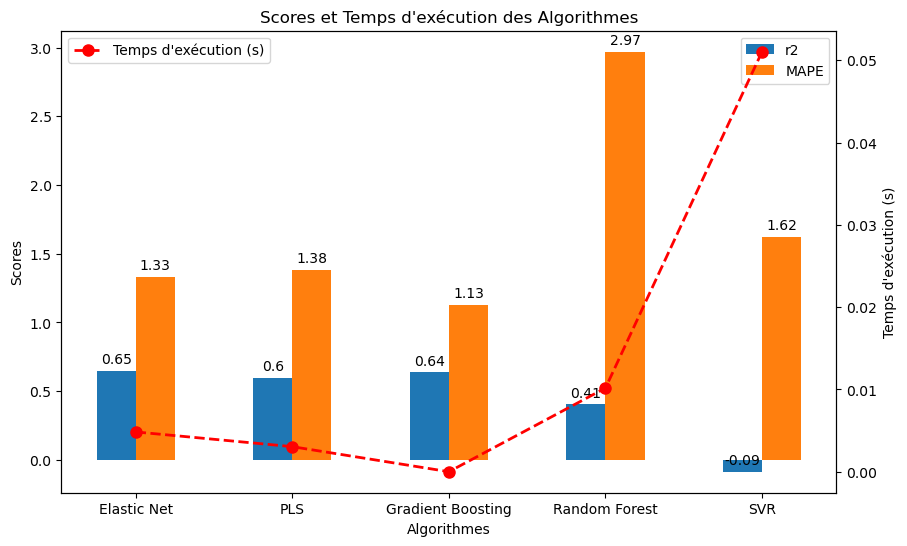

In [35]:
# Créer le graphique en barres
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(models))

bar1 = ax1.bar(index, r2_scores, bar_width, label='r2')
bar2 = ax1.bar(index + bar_width, mape_scores, bar_width, label='MAPE')

ax1.set_xlabel('Algorithmes')
ax1.set_ylabel('Scores')
ax1.set_title('Scores et Temps d\'exécution des Algorithmes')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models.keys())

# Ajouter des étiquettes de valeur aux barres
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax1, bar1)
add_value_labels(ax1, bar2)

# Créer un deuxième axe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, execution_times, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Temps d\'exécution (s)')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.legend(loc='upper left')  # Déplacer la légende vers le coin supérieur gauche

# Ajouter une légende pour les scores
ax1.legend(loc='upper right')

# Afficher le graphique
plt.show()


invalid value encountered in log
invalid value encountered in log


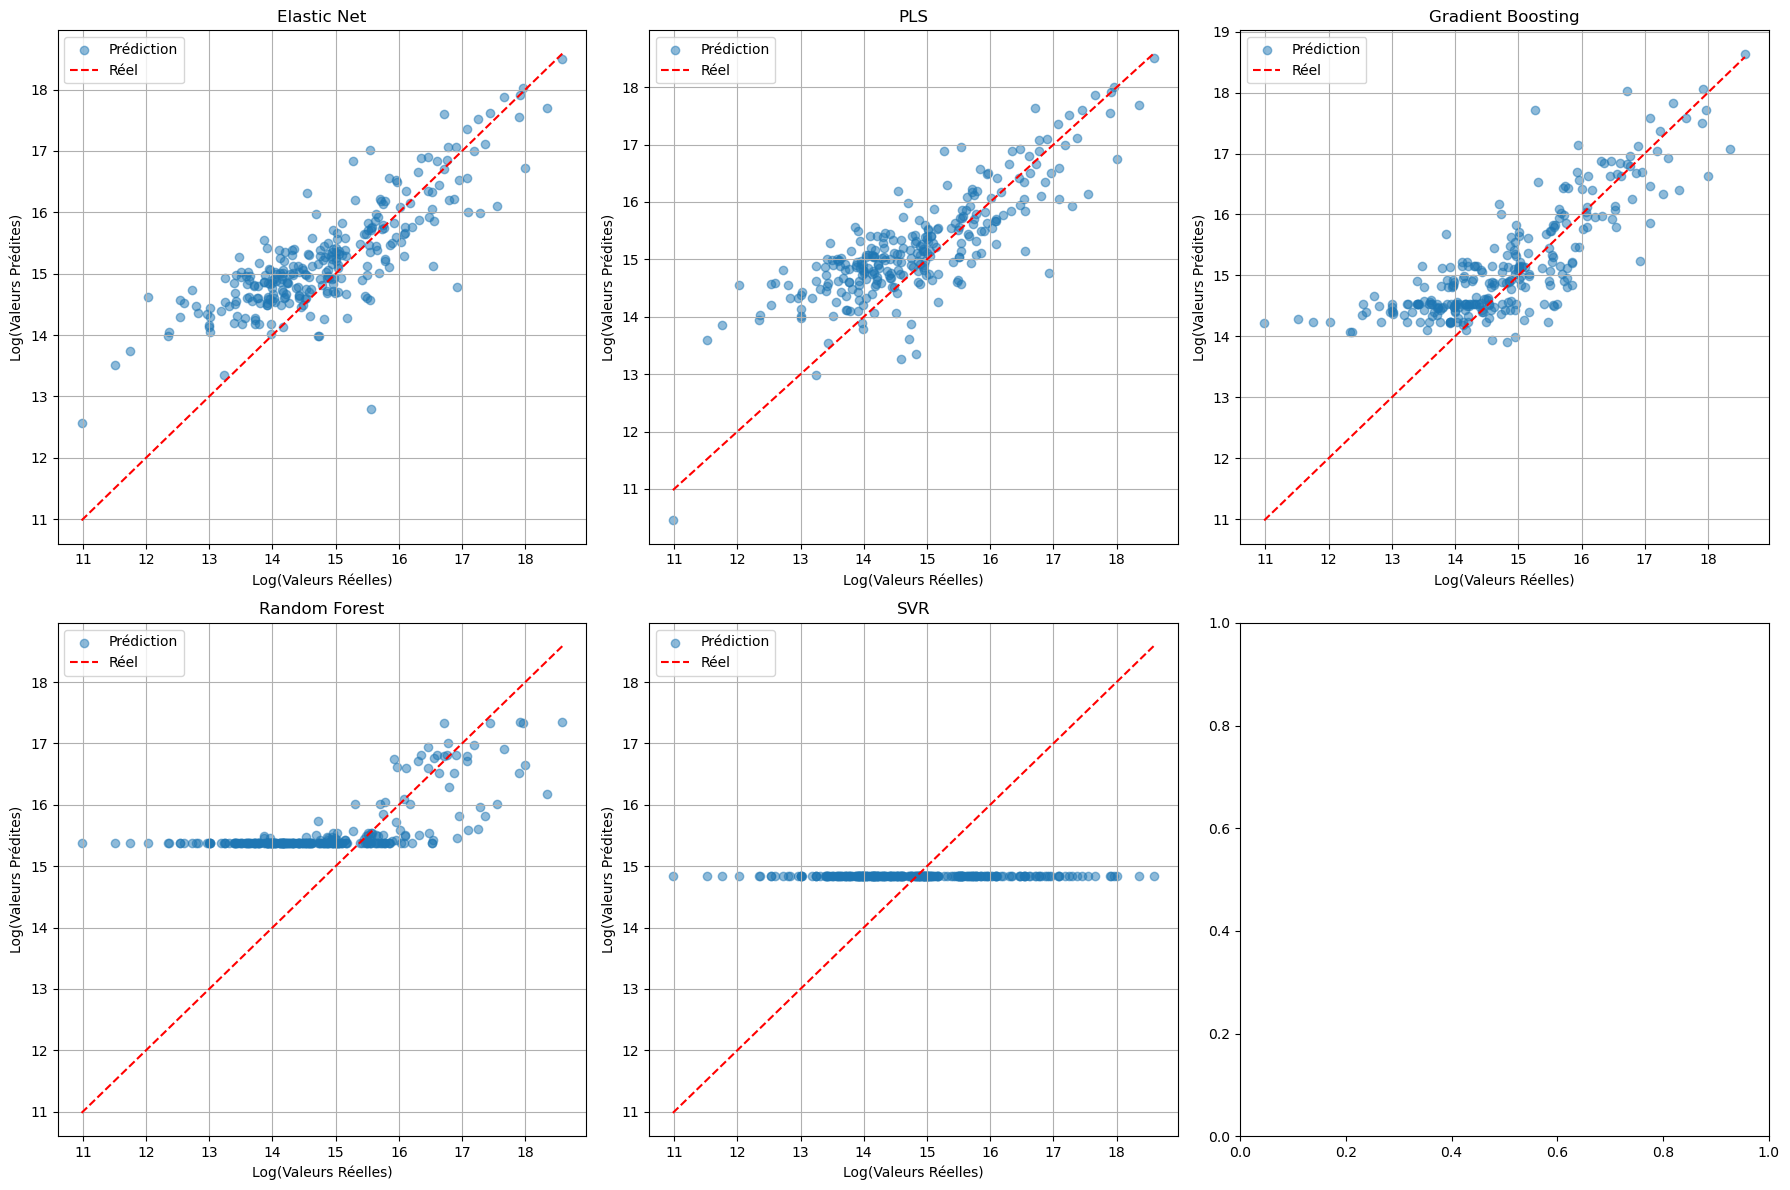

In [36]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Liste des modèles à visualiser
model_names = list(models.keys())

# Parcourir chaque modèle pour tracer le nuage de points
for i, (name, model) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.set_title(name)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Tracer le nuage de points
    ax.scatter(np.log(y_test), np.log(predictions), alpha=0.5)
    ax.plot([min(np.log(y_test)), max(np.log(y_test))], [min(np.log(y_test)), max(np.log(y_test))], color='red', linestyle='--')
    
    # Ajouter des étiquettes et légendes
    ax.set_xlabel('Log(Valeurs Réelles)')
    ax.set_ylabel('Log(Valeurs Prédites)')
    ax.legend(['Prédiction', 'Réel'])
    ax.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


### 2. Avec le features selection

In [40]:
dfB2 = df_fs.copy()

In [41]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = dfB2.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = dfB2['Conso_Totale_WN']

In [42]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Hospital_General_Medical_Surgical',
       'Laboratory', 'Museum', 'Non_Refrigerated_Warehouse', 'Other',
       'Other_Recreation', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Police_Station', 'Restaurant', 'Self_Storage_Facility',
       'Supermarket_Grocery_Store', 'Urgent_Care_Clinic_Other_Outpatient',
       'Worship_Facility', 'rateBuilding', 'surfaceEtage', 'surfaceParBat'],
      dtype='object')
(1382, 25)


In [43]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 25)
(277, 25)


In [44]:
# Initialiser les modèles
models = {
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000),
    "PLS": PLSRegression(n_components=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(kernel='rbf') 
}

# Initialiser les listes pour stocker les scores et les temps d'exécution
r2_scores = []
mape_scores = []
execution_times = []

# Entraîner et évaluer les modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2_scores.append(r2)  
    mape_scores.append(mape) 
    # Calculer et stocker le temps d'exécution
    start_time = time.time()
    model.predict(X_test) 
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time) 
    print(f"Model: {name}")
    print(f"R² Score: {r2}")
    print(f"MAPE: {mape}")
    print(f"Execution Time: {execution_time} seconds")
    print("----------------------")


Model: Elastic Net
R² Score: 0.7779930091519212
MAPE: 1.0837875010685505
Execution Time: 0.0 seconds
----------------------
Model: PLS
R² Score: 0.7750903809913974
MAPE: 1.1226823912990667
Execution Time: 0.0 seconds
----------------------
Model: Gradient Boosting
R² Score: 0.642288415502358
MAPE: 1.1184066361434493
Execution Time: 0.0 seconds
----------------------
Model: Random Forest
R² Score: 0.4066414100356557
MAPE: 2.9696414864053815
Execution Time: 0.01563405990600586 seconds
----------------------
Model: SVR
R² Score: -0.0858789686454422
MAPE: 1.621354376607632
Execution Time: 0.05791020393371582 seconds
----------------------


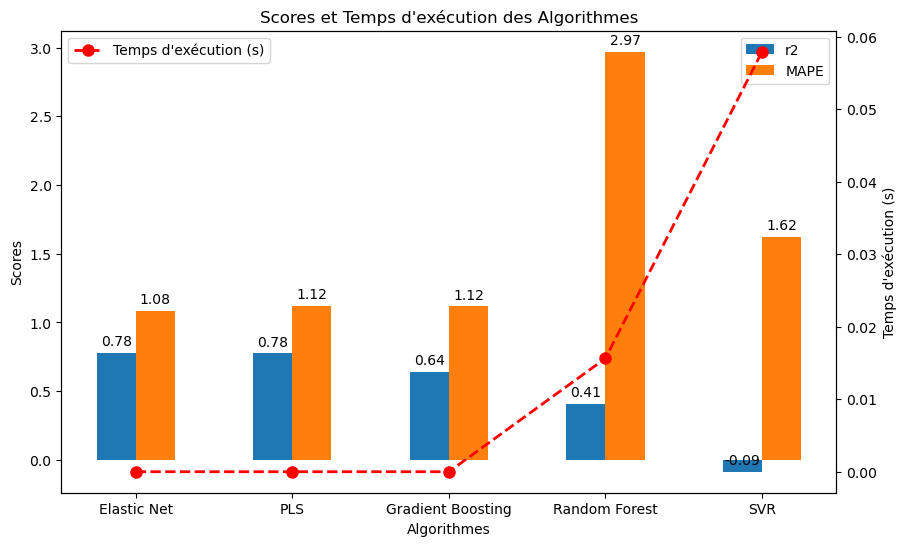

In [45]:
# Créer le graphique en barres
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(models))

bar1 = ax1.bar(index, r2_scores, bar_width, label='r2')
bar2 = ax1.bar(index + bar_width, mape_scores, bar_width, label='MAPE')

ax1.set_xlabel('Algorithmes')
ax1.set_ylabel('Scores')
ax1.set_title('Scores et Temps d\'exécution des Algorithmes')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models.keys())

# Ajouter des étiquettes de valeur aux barres
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax1, bar1)
add_value_labels(ax1, bar2)

# Créer un deuxième axe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, execution_times, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Temps d\'exécution (s)')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.legend(loc='upper left')  # Déplacer la légende vers le coin supérieur gauche

# Ajouter une légende pour les scores
ax1.legend(loc='upper right')

# Afficher le graphique
plt.show()


invalid value encountered in log


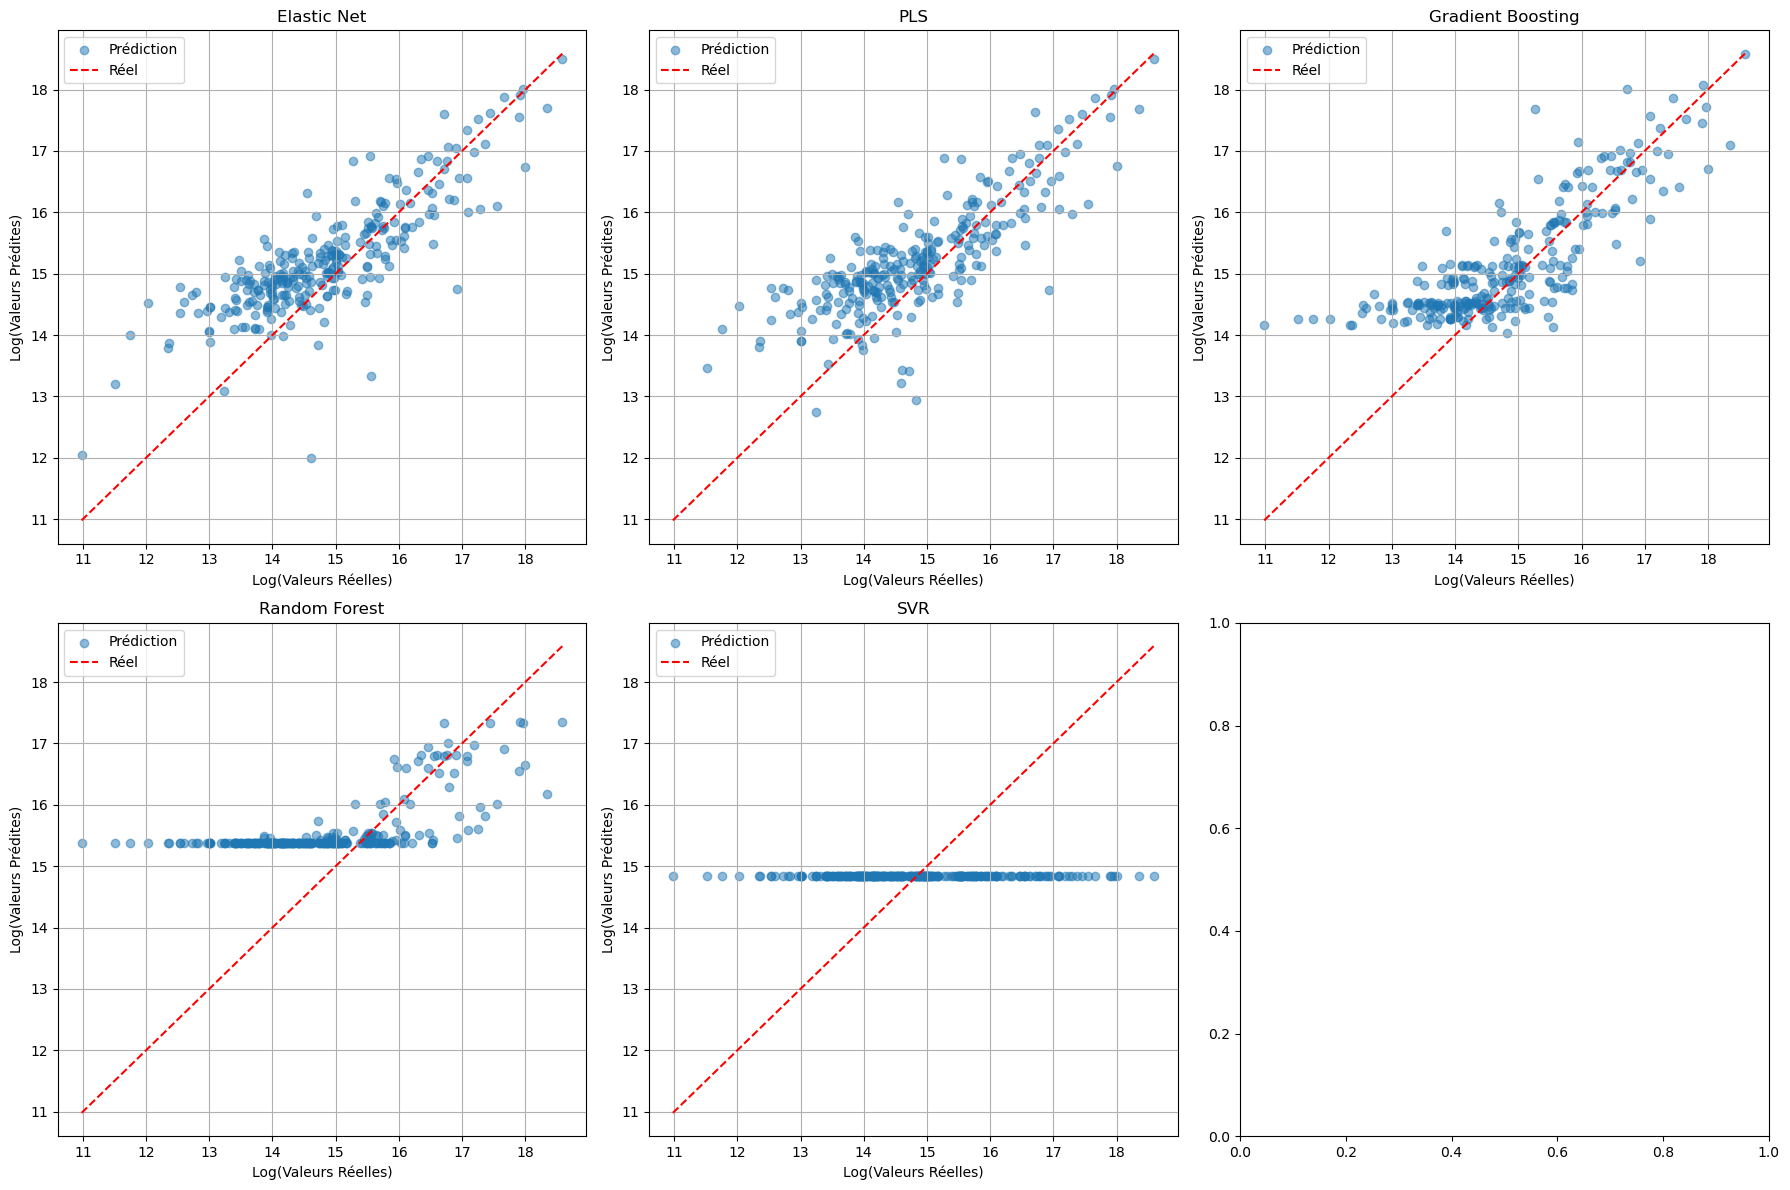

In [46]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Liste des modèles à visualiser
model_names = list(models.keys())

# Parcourir chaque modèle pour tracer le nuage de points
for i, (name, model) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.set_title(name)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Tracer le nuage de points
    ax.scatter(np.log(y_test), np.log(predictions), alpha=0.5)
    ax.plot([min(np.log(y_test)), max(np.log(y_test))], [min(np.log(y_test)), max(np.log(y_test))], color='red', linestyle='--')
    
    # Ajouter des étiquettes et légendes
    ax.set_xlabel('Log(Valeurs Réelles)')
    ax.set_ylabel('Log(Valeurs Prédites)')
    ax.legend(['Prédiction', 'Réel'])
    ax.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


## C. Influence de la transformation log de variable cible (y)

In [55]:
dfC1 = df_fs.copy()

In [56]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = dfC1.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = dfC1['Conso_totale_WN_log']

In [57]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Hospital_General_Medical_Surgical',
       'Laboratory', 'Museum', 'Non_Refrigerated_Warehouse', 'Other',
       'Other_Recreation', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Police_Station', 'Restaurant', 'Self_Storage_Facility',
       'Supermarket_Grocery_Store', 'Urgent_Care_Clinic_Other_Outpatient',
       'Worship_Facility', 'rateBuilding', 'surfaceEtage', 'surfaceParBat'],
      dtype='object')
(1382, 25)


In [58]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 25)
(277, 25)


In [59]:
# Initialiser les modèles
models = {
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000),
    "PLS": PLSRegression(n_components=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(kernel='rbf') 
}

# Initialiser les listes pour stocker les scores et les temps d'exécution
r2_scores = []
mape_scores = []
execution_times = []

# Entraîner et évaluer les modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2_scores.append(r2)  
    mape_scores.append(mape) 
    # Calculer et stocker le temps d'exécution
    start_time = time.time()
    model.predict(X_test) 
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time) 
    print(f"Model: {name}")
    print(f"R² Score: {r2}")
    print(f"MAPE: {mape}")
    print(f"Execution Time: {execution_time} seconds")
    print("----------------------")


Model: Elastic Net
R² Score: 0.29332586583382425
MAPE: 0.05036131678925482
Execution Time: 0.011218786239624023 seconds
----------------------
Model: PLS
R² Score: 0.359318672400583
MAPE: 0.0482441178748474
Execution Time: 0.0 seconds
----------------------
Model: Gradient Boosting
R² Score: 0.7043299754522085
MAPE: 0.03641130525462981
Execution Time: 0.0 seconds
----------------------
Model: Random Forest
R² Score: 0.5706930207519686
MAPE: 0.04281865457891288
Execution Time: 0.01562190055847168 seconds
----------------------
Model: SVR
R² Score: 0.6371430486242446
MAPE: 0.038989099711433266
Execution Time: 0.031183242797851562 seconds
----------------------


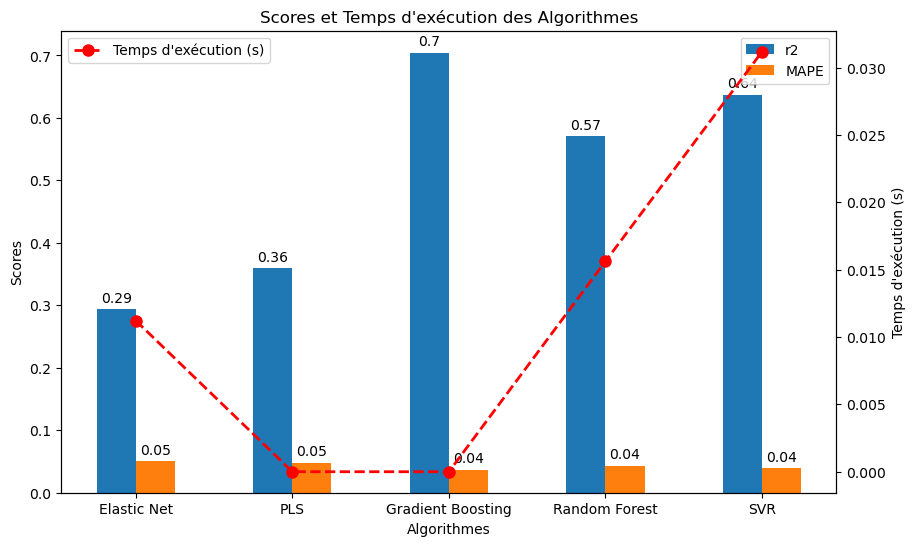

In [60]:
# Créer le graphique en barres
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(models))

bar1 = ax1.bar(index, r2_scores, bar_width, label='r2')
bar2 = ax1.bar(index + bar_width, mape_scores, bar_width, label='MAPE')

ax1.set_xlabel('Algorithmes')
ax1.set_ylabel('Scores')
ax1.set_title('Scores et Temps d\'exécution des Algorithmes')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models.keys())

# Ajouter des étiquettes de valeur aux barres
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax1, bar1)
add_value_labels(ax1, bar2)

# Créer un deuxième axe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(index + bar_width / 2, execution_times, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Temps d\'exécution (s)')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.legend(loc='upper left')  # Déplacer la légende vers le coin supérieur gauche

# Ajouter une légende pour les scores
ax1.legend(loc='upper right')

# Afficher le graphique
plt.show()


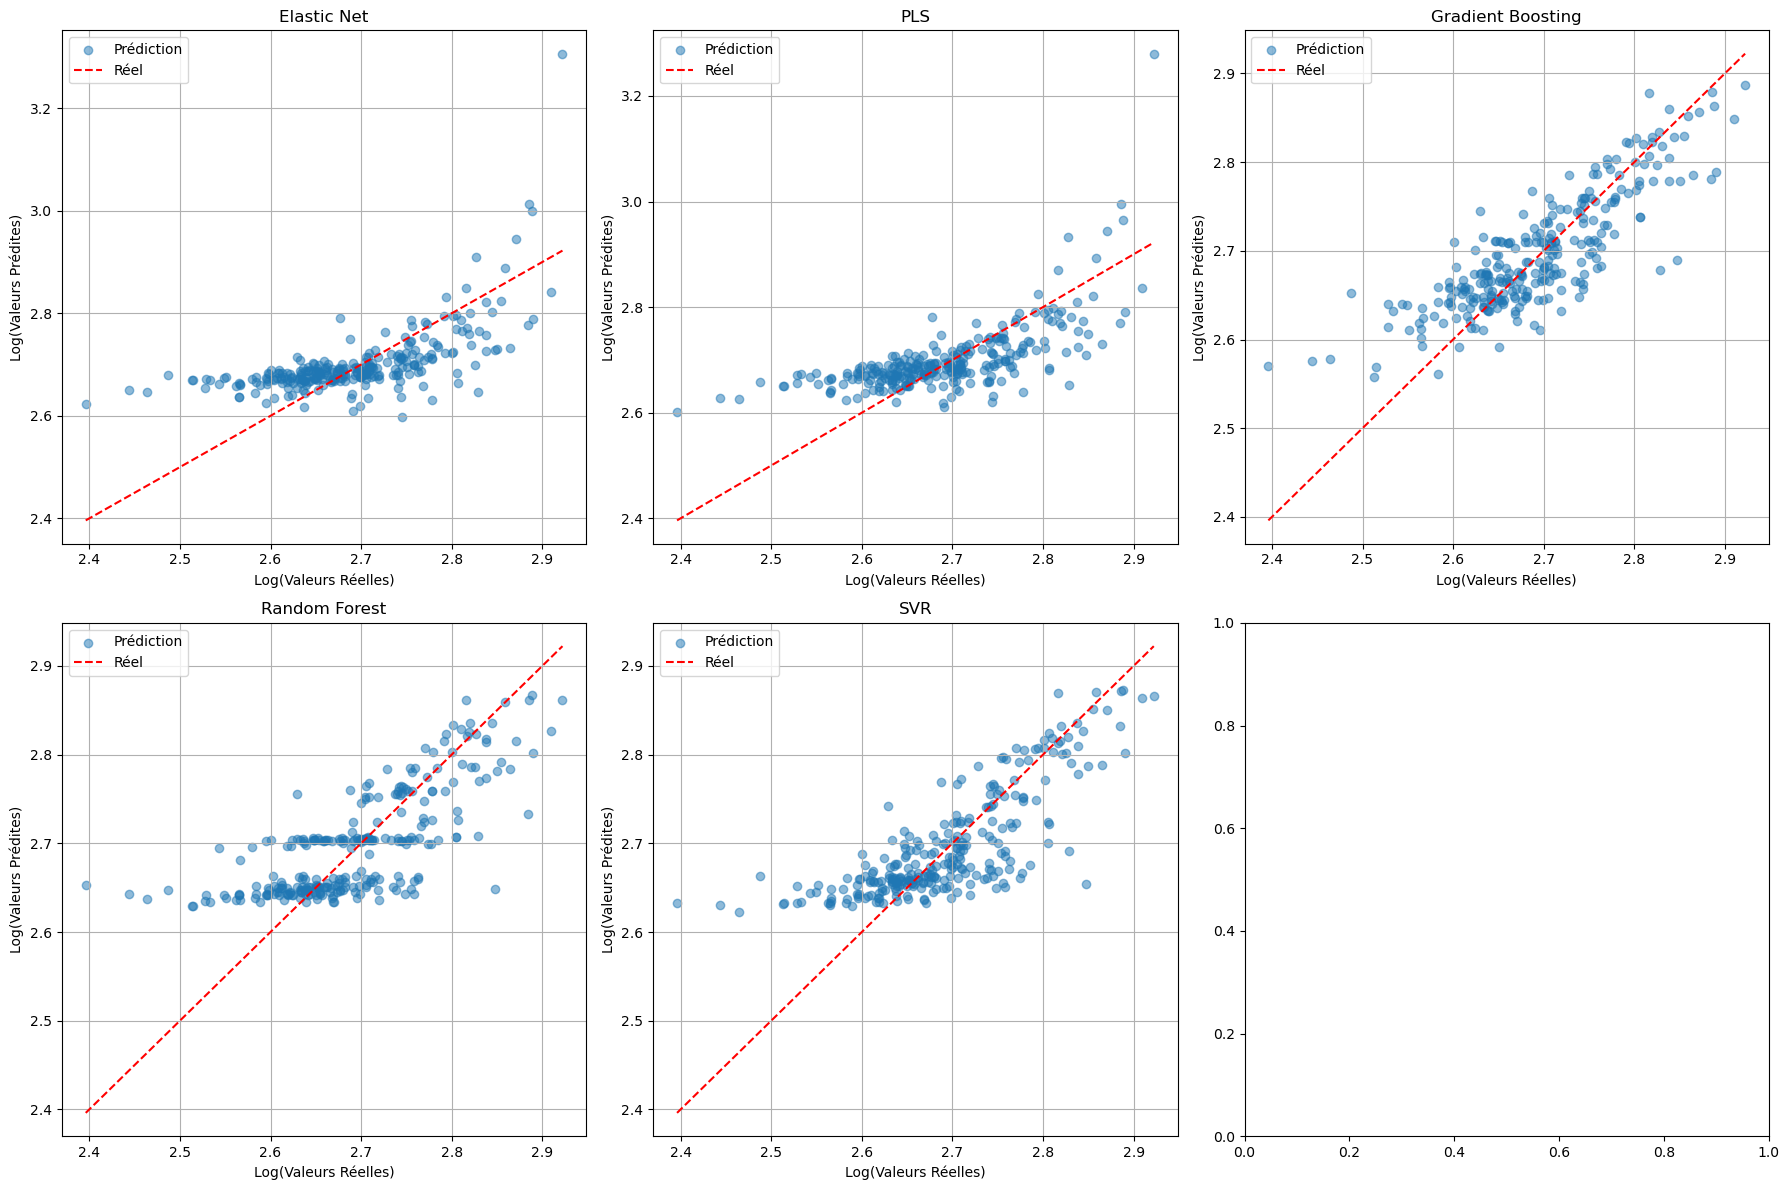

In [61]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Liste des modèles à visualiser
model_names = list(models.keys())

# Parcourir chaque modèle pour tracer le nuage de points
for i, (name, model) in enumerate(models.items()):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    ax.set_title(name)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Tracer le nuage de points
    ax.scatter(np.log(y_test), np.log(predictions), alpha=0.5)
    ax.plot([min(np.log(y_test)), max(np.log(y_test))], [min(np.log(y_test)), max(np.log(y_test))], color='red', linestyle='--')
    
    # Ajouter des étiquettes et légendes
    ax.set_xlabel('Log(Valeurs Réelles)')
    ax.set_ylabel('Log(Valeurs Prédites)')
    ax.legend(['Prédiction', 'Réel'])
    ax.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


## 4. Conclusion sur l'approche 'data-centric'

On remarque des différences notables entre les différents modèles testés, et les configurations associées.
Tout d'abord, on remarque que nos modèles destinés à la régression répondent plutôt bien avec l'elastic net et le PLS. Etant donné que nous sommes dans un problème de régression linéaire, ils sont pertinents. Leur configuration la plus adaptée est tout d'abord de ne pas transformer la variable cible avec le log. Nous remarquons que le feature selection est également positif, cela permet au modèle de ce concentrer uniquement que les variables explicatrices.

Je vais donc retenir le PLS et l'Elastic Net, pour les modèles directement associés aux regression.

Le SVR semble aussi avoir de bons résultats avec un 0.74 obtenu avec un kernel linéaire, néamoins dans la plupart des cas cet algorithmes n'arrive pas à atteindre un résultat même en laissant plusieurs dizaines de minutes le pc tourné. Je ne vais pas donc pas le prendre.

L'autre modèle intéresant est le gradient boosting notamment avec la transformation en log de la variable cible y.
Je vais donc le retenir également.


# IV. Modélisations sur les algorithmes retenus (approche model-centric)

## 1. Elastic Net

**Explications sur le fonctionnement de l'algorithme de l'elastic net:**

L'Elastic Net utilise à la fois la régularisation L1 et L2 pour ajuster les coefficients du modèle de régression. Il permet de bénéficier à la fois de la sélection de variables de la régression Lasso et de la stabilité de la régression Ridge. 
Il est particulièrement utile lorsque les données présentent des corrélations élevées entre les variables et que certaines variables sont fortement corrélées avec la variable cible

L1 = Régression Lasso, cette pénalité a pour effet de forcer certains coefficients à devenir exactement égaux à zéro, ce qui peut conduire à la sélection de variables, ce qui fait de lui un modèle dit parcimonieux.

L2 = Régression Ridge, elle tend plutôt à réduire les coefficients vers zéro de manière continue sans les annuler complètement.

**Les hyperparamètres du modèle :**

Alpha (α) : C'est le paramètre qui contrôle le mélange entre la régularisation L1 (Lasso) et la régularisation L2 (Ridge). Il varie généralement de 0 à 1. Une valeur de 0 correspond à la régression Ridge pure, une valeur de 1 correspond à la régression Lasso pure, et une valeur entre les deux permet de combiner les deux régularisations. Plus alpha est proche de 1, plus le modèle sera parcimonieux.

Lambda L1 & L2 : Ce sont les paramètres de pénalisation qui contrôlent la force de la régularisation L1 et L2. Plus lambda est grand, plus la régularisation est forte, ce qui conduit à des coefficients de modèle plus petits et potentiellement à une plus grande parcimoni

**Les KPI pour mesurer les performances du modèle :**

- MSE : 'Mean Squared Error' qui est la somme des erreurs entre les valeurs prédites et les valeurs réelles de la target. Plus son score est bas, plus le modèle est bon

- RMSE : 'Root Mean Squared Error' qui est la racine du MSE, même interprétation que pour le MSE, plus sa valeur est basse, plus le modèle est bon.

- R² : 'Coefficient de détermination', il mesure la propotion de la variance de la variable cible expliquée par le modèle. Il varie de 0 à 1, où 1 indique un ajustement parfait.

In [96]:
# Prendre le dataframe avec l'application du feature selection
df1_el = df_fs.copy()

In [97]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = df1_el.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = df1_el['Conso_Totale_WN']

In [98]:
# Affichage des variables explicatives dans la matrice X
print(X.columns)
print(X.shape)

Index(['Age_batiment', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Conso_Elec_kBtu_WN', 'Data_Center',
       'Distribution_Center', 'Hospital_General_Medical_Surgical',
       'Laboratory', 'Museum', 'Non_Refrigerated_Warehouse', 'Other',
       'Other_Recreation', 'Other_Utility', 'Other_Specialty_Hospital',
       'Parking', 'Police_Station', 'Restaurant', 'Self_Storage_Facility',
       'Supermarket_Grocery_Store', 'Urgent_Care_Clinic_Other_Outpatient',
       'Worship_Facility', 'rateBuilding', 'surfaceEtage', 'surfaceParBat'],
      dtype='object')
(1382, 25)


In [99]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 25)
(277, 25)


In [100]:
# Mise en place du modèle Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000)

# Entraînement du modèle
elastic_net.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = elastic_net.predict(X_test_scaled)

# Évaluation des performances du modèle
score = elastic_net.score(X_test_scaled, y_test)
print("Coefficient de détermination (R^2) sur l'ensemble de test:", score)

Coefficient de détermination (R^2) sur l'ensemble de test: 0.7743501437315938


In [101]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calcul du R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

# Calcul du MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

Mean Squared Error: 38296920357593.836
Root Mean Squared Error: 6188450.561941481
R²: 0.7743501437315938
MAPE: 1.09597746294195


In [102]:
# Validation croisée avec 10 plis
cv_scores = cross_val_score(elastic_net, X_train_scaled, y_train, cv=10, scoring='r2')

# Affichage des scores de validation croisée
print("Scores de validation croisée :", cv_scores)
print("Moyenne des scores de validation croisée :", cv_scores.mean())

Scores de validation croisée : [0.70019283 0.03354596 0.76440948 0.78414051 0.61484774 0.49913594
 0.81935649 0.65647202 0.87554771 0.36405354]
Moyenne des scores de validation croisée : 0.6111702225134137


Avec 0.6111 de score moyen sur 10 plis, le modèle pert en performance quand on le teste sur différents plis du dataset, avec notamment deux scores très faibles de 0.03 & de 0.36.

In [103]:
# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'alpha': np.linspace(0.01, 0.5, 1),
    'l1_ratio': np.linspace(0.1, 0.9, 1),
    'max_iter': [100000, 200000, 300000]
}

# Créer une instance de GridSearchCV pour le modèle Elastic Net
grid_search = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Exécuter la recherche sur la grille en utilisant les données d'entraînement
grid_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Obtenir le meilleur modèle trouvé
best_model = grid_search.best_estimator_

# Prédiction sur l'ensemble de test avec le meilleur modèle
y_pred = best_model.predict(X_test_scaled)

# Évaluation des performances du meilleur modèle
bestscore_elasticnet = best_model.score(X_test_scaled, y_test)
print("Coefficient de détermination R²) sur l'ensemble de test avec le meilleur modèle:", bestscore_elasticnet)


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Meilleurs hyperparamètres: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 300000}
Coefficient de détermination R²) sur l'ensemble de test avec le meilleur modèle: 0.7758790524494699


invalid value encountered in log


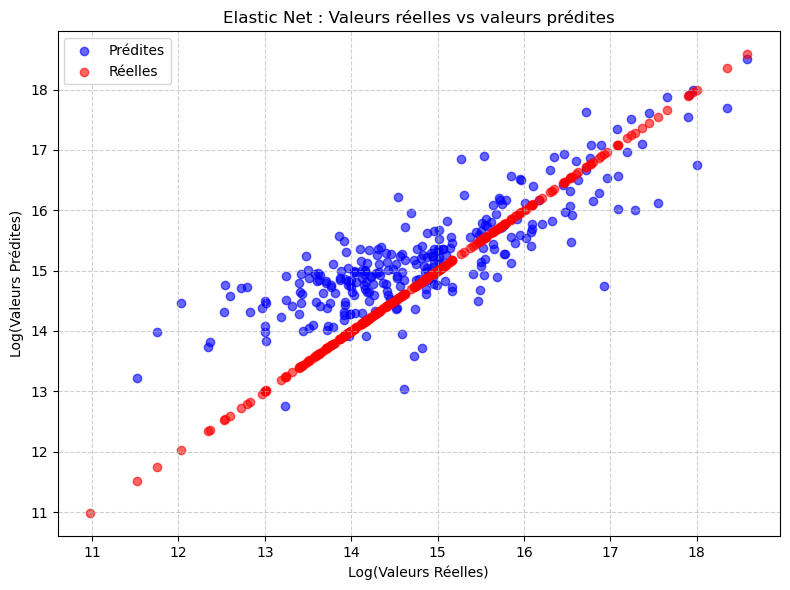

In [104]:
# Calculer le logarithme des valeurs réelles et prédites
y_test_log = np.log(y_test)
y_pred_log = np.log(y_pred)

# Nuage de points valeurs réelles vs valeurs prédites avec des couleurs différenciées
plt.figure(figsize=(8, 6))
plt.scatter(y_test_log, y_pred_log, color='blue', alpha=0.6, label='Prédites') 
plt.scatter(y_test_log, y_test_log, color='red', alpha=0.6, label='Réelles')   
plt.xlabel('Log(Valeurs Réelles)')
plt.ylabel('Log(Valeurs Prédites)')
plt.title('Elastic Net : Valeurs réelles vs valeurs prédites')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Malgré, la GridSearchCV, notre modèle semble atteindre ses limites avec un score d'environ de 0.78. Notre objectif étant de 0.8, je vais essayer une permution des colonnes pour voir si nous pouvons avoir mieux.

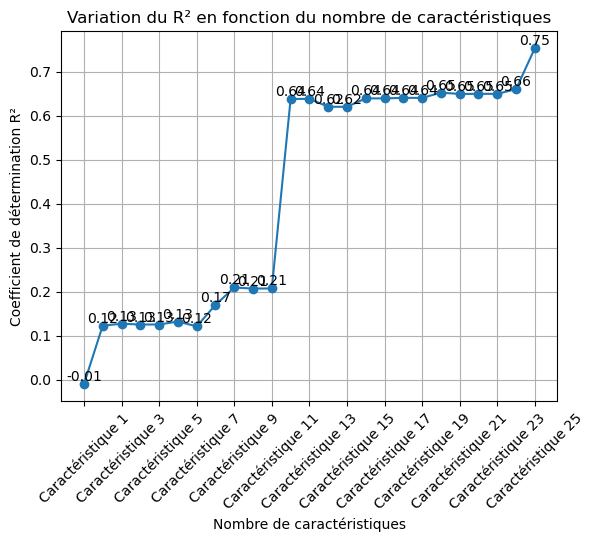

In [64]:
# Initialisation de la liste pour stocker les R²
r2_scores = []

# Itération sur chaque permutation de colonnes
for num_features in range(1, X_train_scaled.shape[1] + 1):
    # Sélectionner les premières 'num_features' colonnes pour X_train_scaled
    X_train_permuted = X_train_scaled[:, :num_features]
    
    # Créer une instance de modèle Elastic Net
    model = ElasticNet()
    
    # Entraîner le modèle avec les données d'entraînement permutées
    model.fit(X_train_permuted, y_train)
    
    # Prédire sur les données de test avec le modèle entraîné
    y_pred = model.predict(X_test_scaled[:, :num_features])
    
    # Calculer le R² pour le modèle actuel
    r2 = r2_score(y_test, y_pred)
    
    # Stocker le R² dans la liste
    r2_scores.append(r2)

# Tracer le graphique des variations du R²
plt.plot(range(1, X_train_scaled.shape[1] + 1), r2_scores, marker='o')
plt.xlabel('Nombre de caractéristiques')
plt.ylabel('Coefficient de détermination R²')
plt.title('Variation du R² en fonction du nombre de caractéristiques')
plt.grid(True)

# Afficher uniquement un sous-ensemble des noms de caractéristiques
step = max(1, len(r2_scores) // 10)  # Pas pour afficher les noms
plt.xticks(range(1, X_train_scaled.shape[1] + 1, step), ['Caractéristique {}'.format(i) for i in range(1, X_train_scaled.shape[1] + 1)][::step], rotation=45)

# Ajouter les étiquettes de valeurs du R²
for i, r2 in enumerate(r2_scores):
    plt.text(i + 1, r2, f"{r2:.2f}", ha='center', va='bottom')

plt.show()


## 2. GradientBoosting

Le gradient boosting est une méthode d'ensemble, ce qui signifie qu'elle combine plusieurs modèles d'apprentissage pour obtenir de meilleures performances globales. Contrairement aux méthodes comme le bagging (par exemple, Random Forest), où les modèles sont entraînés de manière indépendante, le gradient boosting construit les modèles de manière séquentielle.

Le gradient boosting fonctionne en minimisant une fonction de perte (loss function), qui mesure la différence entre les valeurs prédites et les valeurs réelles. Pour minimiser cette fonction de perte, le modèle est entraîné à chaque étape en ajustant les prédictions dans la direction qui réduit le gradient de la fonction de perte.



- Nombre d'estimateurs (n_estimators) : Il s'agit du nombre d'arbres de décision qui seront utilisés dans l'ensemble. Une valeur plus élevée peut améliorer les performances du modèle, mais peut également augmenter le temps d'entraînement.
- 
Taux d'apprentissage (learning rate ou eta) : Ce paramètre contrôle la taille des pas que l'algorithme prend à chaque étape d'apprentissage. Une valeur plus petite signifie que le modèle apprendra plus lentement, mais peut converger vers une solution meilleure et plus stable
- Profondeur maximale de l'arbre (max_depth) : Cela limite la profondeur maximale des arbres de décision dans l'ensemble. Limiter la profondeur peut aider à prévenir le surapprentissage.

- Nombre minimal d'échantillons par feuille (min_child_samples) : Ce paramètre contrôle le nombre minimum d'échantillons requis pour qu'un nœud soit considéré comme une feuille dans l'arbre. Il peut aider à contrôler la complexité de l'arbre et à prévenir le surapprentissage.ssage.

In [87]:
df_gb = df_fs_sf.copy()
df_gb.shape

(1382, 29)

In [88]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = df_gb.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = df_gb['Conso_totale_WN_log']

In [89]:
# Afficher la structure de la matrice X
print(X.shape)
print(X.columns)

(1382, 27)
Index(['Age_batiment', 'Surface_totale', 'NbEtages', 'Conso_GazNat_kBtu_WN',
       'Conso_Vapeur_kBtu_WN', 'Data_Center', 'Distribution_Center',
       'Food_Service', 'Hospital_General_Medical_Surgical', 'Laboratory',
       'Non_Refrigerated_Warehouse', 'Other_Restaurant_Bar',
       'Other_Specialty_Hospital', 'Parking', 'Performing_Arts',
       'Police_Station', 'Pre_school_Daycare', 'Restaurant',
       'Self_Storage_Facility', 'Supermarket_Grocery_Store',
       'Urgent_Care_Clinic_Other_Outpatient', 'Worship_Facility',
       'rateParking', 'rateBuilding', 'surfaceEtage', 'surfaceParBat',
       'nombre_usages'],
      dtype='object')


In [90]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1105, 27)
(277, 27)


In [91]:
# Création d'une instance du modèle GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()

# Entraînement du modèle sur l'ensemble d'entraînement
gb_regressor.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = gb_regressor.predict(X_test)

# Évaluation du modèle
r2_value = r2_score(y_test, y_pred)
print("R² sur l'ensemble de test:", r2_value)

R² sur l'ensemble de test: 0.7255100170510904


In [92]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calcul du R²
r_squared = r2_score(y_test, y_pred)
print("R²:", r_squared)

# Calcul du MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

Mean Squared Error: 0.43544363590224827
Root Mean Squared Error: 0.6598815317178139
R²: 0.7255100170510904
MAPE: 0.03474465761961218


In [93]:
# Validation croisée avec 10 plis
cv_scores = cross_val_score(gb_regressor, X_train_scaled, y_train, cv=10, scoring='r2')

# Affichage des scores de validation croisée
print("Scores de validation croisée :", cv_scores)
print("Moyenne des scores de validation croisée :", cv_scores.mean())

Scores de validation croisée : [0.66565996 0.68909693 0.72848704 0.79236285 0.81877716 0.74795603
 0.76554044 0.70361434 0.77596569 0.78416296]
Moyenne des scores de validation croisée : 0.7471623395905558


In [94]:
# Définir les hyperparamètres à rechercher
param_grid = {
    'n_estimators': [50, 100, 250],  # Nombre d'estimateurs dans le gradient boosting
    'learning_rate': [0.1, 0.1, 0.3],  # Taux d'apprentissage
    'max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum d'échantillons requis pour être une feuille
}

# Initialiser le modèle Gradient Boosting
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Créer un objet GridSearchCV
grid_search = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, cv=10, scoring='r2')

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)
print("Meilleur score R² trouvé:", grid_search.best_score_)
bestscore_gb = grid_search.best_score_

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)


Meilleurs hyperparamètres trouvés:
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Meilleur score R² trouvé: 0.749712523580623


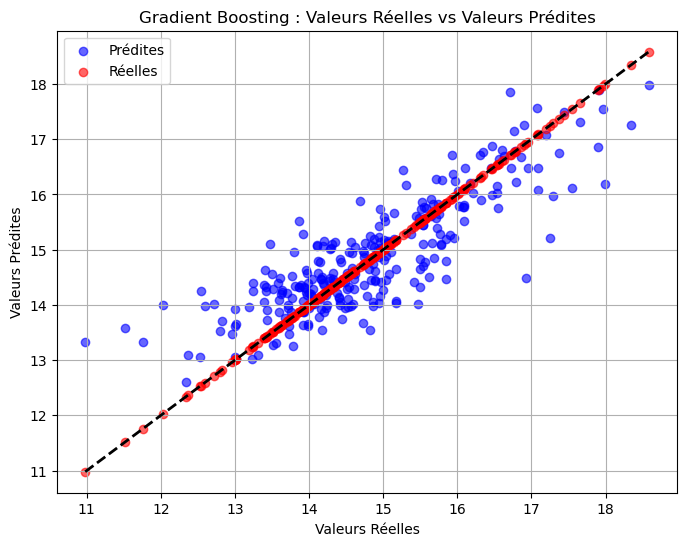

In [95]:
# Nuage de points valeurs réelles vs valeurs prédites avec des couleurs différenciées
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Prédites') 
plt.scatter(y_test, y_test, color='red', alpha=0.6, label='Réelles')   
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Gradient Boosting : Valeurs Réelles vs Valeurs Prédites')
plt.legend()
plt.grid(True)
plt.show()


## 3. PLS

In [41]:
df_pls = df_fs.copy()

In [42]:
# Création de la matrice X pour les variables explicatives et y pour la target
X = df_pls.drop(['Conso_totale_WN_log','Conso_Totale_WN'], axis=1)
y = df_pls['Conso_Totale_WN']

In [43]:
# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données avec RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Création d'une instance du modèle PLS avec 10 composantes
pls = PLSRegression(n_components=10)

# Entraînement du modèle
pls.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = pls.predict(X_test)

# Calcul du coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


R-squared: 0.7750903809913974


In [46]:
# Validation croisée avec 10 plis
cv_scores = cross_val_score(pls, X_train_scaled, y_train, cv=10, scoring='r2')

# Affichage des scores de validation croisée
print("Scores de validation croisée :", cv_scores)
print("Moyenne des scores de validation croisée :", cv_scores.mean())

Scores de validation croisée : [0.70951773 0.05173174 0.76304492 0.78933053 0.61058064 0.50157521
 0.81606958 0.6653623  0.87471321 0.35986285]
Moyenne des scores de validation croisée : 0.6141788708716472


Nombre de composantes: 1 - R²: 0.21788128169014787
Nombre de composantes: 2 - R²: 0.3840210659374862
Nombre de composantes: 3 - R²: 0.6973900981602853
Nombre de composantes: 4 - R²: 0.7282053504518804
Nombre de composantes: 5 - R²: 0.7291074212749901
Nombre de composantes: 6 - R²: 0.7370966238743454
Nombre de composantes: 7 - R²: 0.775476346447421
Nombre de composantes: 8 - R²: 0.7746696958347546
Nombre de composantes: 9 - R²: 0.7751510328882898
Nombre de composantes: 10 - R²: 0.7750903809913974
Nombre de composantes: 11 - R²: 0.7750423699510662
Nombre de composantes: 12 - R²: 0.7750467059233641
Nombre de composantes: 13 - R²: 0.7750461394918771
Nombre de composantes: 14 - R²: 0.7750457972367362
Nombre de composantes: 15 - R²: 0.7750459321513307


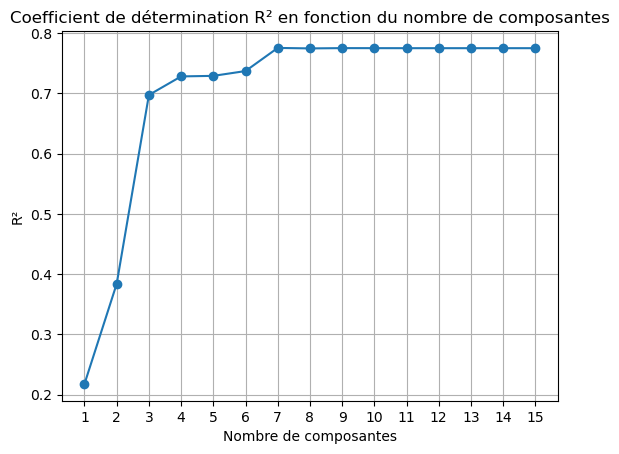

In [47]:
# Définition des hyperparamètres
n_components = 15  # Nombre de composantes
scale = True       # Mise à l'échelle des variables
max_iter = 5000     # Nombre maximal d'itérations
tol = 1e-6         # Tolérance pour la convergence
copy = True        # Copier les données

# Initialisation des listes pour stocker les valeurs de R²
r2_scores = []

# Boucle sur différents nombres de composantes
for n_comp in range(1, n_components + 1):
    # Création et entraînement du modèle PLS avec les hyperparamètres spécifiés
    pls = PLSRegression(n_components=n_comp, scale=scale, max_iter=max_iter, tol=tol, copy=copy)
    pls.fit(X_train, y_train)
    
    # Prédiction sur l'ensemble de test
    y_pred = pls.predict(X_test)
    
    # Calcul du coefficient de détermination R²
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Affichage du R² pour chaque nombre de composantes
    print("Nombre de composantes:", n_comp, "- R²:", r2)

# Tracé du R² en fonction du nombre de composantes
plt.figure()
plt.plot(range(1, n_components + 1), r2_scores, marker='o')
plt.title('Coefficient de détermination R² en fonction du nombre de composantes')
plt.xlabel('Nombre de composantes')
plt.ylabel('R²')
plt.xticks(np.arange(1, n_components + 1))
plt.grid(True)
plt.show()

Le nombre optimal de composantes semble être atteint à partir de 7 avec un R² de 0.775476346447421.
Nous allons pousuivre en ajustant les hyperpramètres restants.

In [48]:
# Définition de l'espace des hyperparamètres à rechercher
param_grid = {
    'n_components': [7, 9, 11, 15],
    'scale': [True, False],
    'max_iter': [10, 25, 50, 100, 200, 300],
    'tol': [1e-4, 1e-5, 1e-6],
    'copy': [True, False]
}

# Création de l'estimateur PLS
pls = PLSRegression()

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(pls, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Prédiction sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = grid_search.best_estimator_.predict(X_test)

# Calcul du coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print("R² avec les meilleurs hyperparamètres:", r2)

Meilleurs hyperparamètres: {'copy': True, 'max_iter': 10, 'n_components': 9, 'scale': False, 'tol': 0.0001}
R² avec les meilleurs hyperparamètres: 0.7789786687828907


Malgré plusieurs essais, en jouant avec les hyperparamètres de notre dictionnaire, il semble que nous stagnons avec un R² de 0.7789 qui reste un bon score malgré un objectif de 0.8 non atteint. 

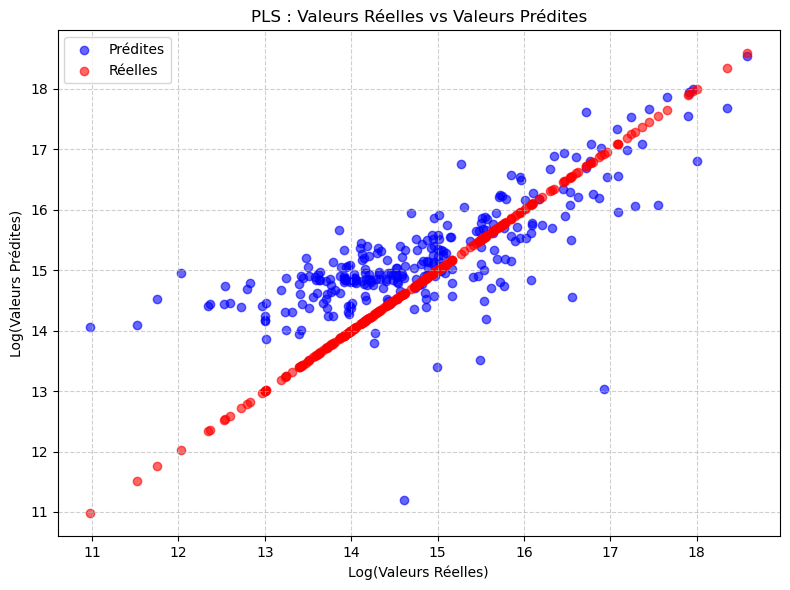

In [49]:
# Calculer le logarithme des valeurs réelles et prédites
y_test_log = np.log(y_test)
y_pred_log = np.log(y_pred)

# Nuage de points valeurs réelles vs valeurs prédites avec des couleurs différenciées
plt.figure(figsize=(8, 6))
plt.scatter(y_test_log, y_pred_log, color='blue', alpha=0.6, label='Prédites') 
plt.scatter(y_test_log, y_test_log, color='red', alpha=0.6, label='Réelles')   
plt.xlabel('Log(Valeurs Réelles)')
plt.ylabel('Log(Valeurs Prédites)')
plt.title('PLS : Valeurs Réelles vs Valeurs Prédites')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


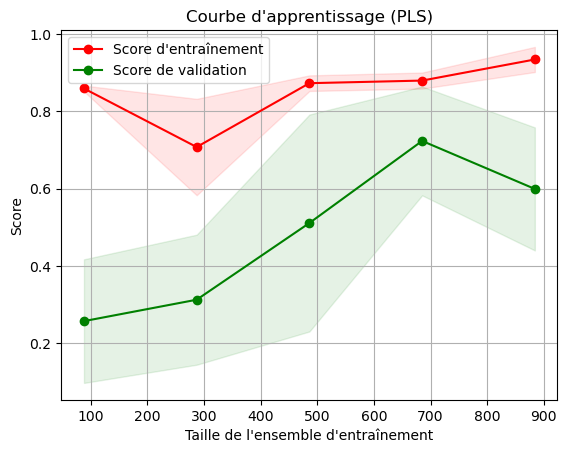

In [50]:
from sklearn.model_selection import learning_curve

# Définition de la fonction pour tracer la courbe d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Score de validation")

    plt.legend(loc="best")
    return plt

# Création de l'estimateur PLS avec les meilleurs hyperparamètres trouvés
best_pls = PLSRegression(**grid_search.best_params_)

# Tracer la courbe d'apprentissage
title = "Courbe d'apprentissage (PLS)"
plot_learning_curve(best_pls, title, X_train, y_train, cv=5, n_jobs=-1)

plt.show()


# V. Conclusion sur les prédictions en consommation des bâtiments 

Notre objectif n'est pas complètement atteint où notre meilleur R² obtenu est 0.7789 avec le PLS, avec cette combinaison d'hyperparamètres :

Meilleurs hyperparamètres: {'copy': True, 'max_iter': 10, 'n_components': 9, 'scale': False, 'tol': 0.0001}
R² avec les meilleurs hyperparamètres: 0.7789786687828907

L'elastic net répond également plutôt bien pour notre problème de régression, ce qui est en accord avec notre problèmatique de métier de prédiction d'une valeur numérique (donc de la régression). 
Il a un score très proche avec cette combinaison d'hyperparamètre : 
Meilleurs hyperparamètres: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 300000}
Coefficient de détermination R²) sur l'ensemble de test avec le meilleur modèle: 0.7758790524494699
Néanmoins, on note tout de même une perte d'efficatité lors qu'on utilise la validation croisée où les deux algorithmes ont un score moyen de 0.61 sur 10 plis. 

Enfin, le gradient boosting est un modèle plutôt intéressant car nous arrivons à avoir un score de 0.74

